# Analyzing GEOJson segmentation data using cellseg_gsontools

https://okunator.github.io/cellseg_gsontools/getting_started/quick_start/

In [1]:
from cellseg_gsontools.utils import read_gdf
from cellseg_gsontools.plotting import plot_gdf
from cellseg_gsontools.geometry import shape_metric

from cellseg_gsontools.graphs import fit_graph
from cellseg_gsontools.utils import set_uid
from cellseg_gsontools.links import weights2gdf

from pathlib import Path

import pandas as pd
import json
import pickle
import networkx as nx
import matplotlib.pyplot as plt


# Here we use the original segmentation files from Yuri Tolkach:
https://uni-koeln.sciebo.de/s/xRpvTwx45uSlK2K - sciebo orginal from Tolkach
## Slide localisation and localisation of Juna's GeoJsons
Slide locaten on cheops1: /projects/ag-bozek/data/eso/cgn-slides/nonflot
GEOJson location: https://uni-koeln.sciebo.de/s/qrYzQ3gTDug3T6v    -  sciebo eso-geojsons-mod 

In [2]:
import warnings
warnings.filterwarnings('ignore')
#warnings.filterwarnings('default')

In [3]:
def select_top_10_percent(df, max=200, ascending=False):
    def select_top_10_percent_(group, max=200, ascending=False):
        n = min(int(len(group) * 0.1), max)  # Calculate the top 10%, ensure at least 1 sample is selected
        return group.sort_values(by='patch-attr', ascending=ascending).head(n)
    return df.groupby('slide-fn', group_keys=False).apply(lambda x: select_top_10_percent_(x,max,ascending))


parquet_file = '../data/df_full.parquet'

df_full= pd.read_parquet(parquet_file, engine="fastparquet")

df_pos_complete = df_full[ df_full['patch-attr'] > 0. ]
df_neg_complete = df_full[ df_full['patch-attr'] < 0. ]

df_pos_true = df_pos_complete[df_pos_complete['pat-label'] == 1]
df_neg_true = df_neg_complete[df_neg_complete['pat-label'] == 0]

df_pos_true_top = select_top_10_percent(df_pos_true)
df_neg_true_top = select_top_10_percent(df_neg_true, ascending=True)

df_pos = df_pos_true_top
df_neg = df_neg_true_top

The WSIs had a tile size of 512x512 pixels at x40. The .parquets have the columns 'patch-y' and 'patch-x' . If you would like to analyse the high attention parts of the .geojsons, you can take those columns in the df_pos, df_neg dataframes, multiply the values times 512 to get top-left corner coordinate of the patch, and retrieve the corresponding cells.

For example, if there was a row with patch-y = 20, patch-x = 10, you need to get all the cells of the corresponding .geojson whose nuclei centroids coordinates verify 10240 < y < 10240+512 , 5120 < x < 5120 + 512

In [4]:
df_pos.info()
df_pos.head()

<class 'pandas.core.frame.DataFrame'>
Index: 241 entries, 2140 to 507
Columns: 528 entries, num-cells to pat-label
dtypes: float32(1), float64(516), int64(10), object(1)
memory usage: 995.1+ KB


,num-cells,area-mean,area-median,area-variance,area-skewness,area-kurtosis,num-cells-class-1,num-cells-class-1-ratio,area-class-1-mean,area-class-1-median,...,patch-x,patch-attr,slide-fn,pseudo-spatial-assoc-class-1,pseudo-spatial-assoc-class-2,pseudo-spatial-assoc-class-3,pseudo-spatial-assoc-class-4,pseudo-spatial-assoc-class-5,pseudo-spatial-assoc-class-6,pat-label
2140,126,463.269841,421.0,33894.694603,1.685272,5.435433,89,0.706349,501.730337,467.0,...,241,0.520525,C 13.35827 he - 2021-12-14 15.48.36.ndpi,0.337017,NaN,-0.129834,NaN,NaN,-0.113260,1
2053,96,493.302083,453.0,48166.297259,1.198908,3.734392,92,0.958333,504.793478,460.0,...,224,0.496352,C 13.35827 he - 2021-12-14 15.48.36.ndpi,0.854545,NaN,-0.040000,NaN,NaN,NaN,1
2067,93,532.129032,528.0,32498.483170,0.779695,0.773212,92,0.989247,535.380435,528.5,...,224,0.494977,C 13.35827 he - 2021-12-14 15.48.36.ndpi,0.961832,NaN,NaN,NaN,NaN,NaN,1
2005,105,453.923810,415.0,33656.244139,0.526598,-0.355899,36,0.342857,555.666667,536.0,...,208,0.466593,C 13.35827 he - 2021-12-14 15.48.36.ndpi,0.100671,NaN,0.080537,-0.077181,NaN,-0.110738,1
2080,121,460.661157,441.0,34078.392562,1.312234,3.662701,82,0.677686,498.792683,456.0,...,224,0.447581,C 13.35827 he - 2021-12-14 15.48.36.ndpi,0.477143,NaN,-0.042857,-0.040000,NaN,-0.165714,1


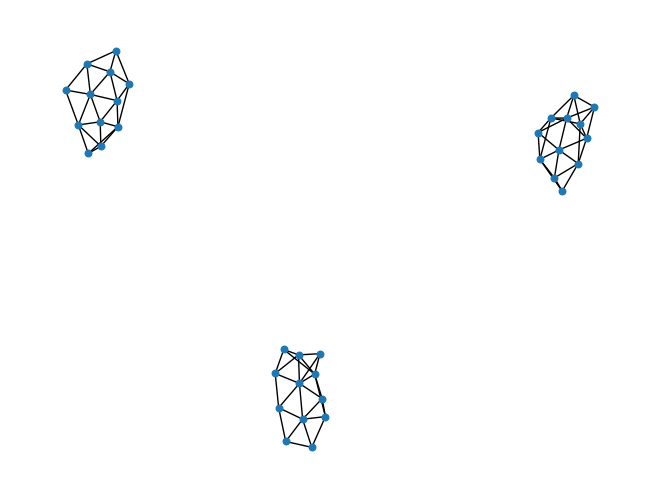

In [5]:
df = df_pos
df = df.reset_index()

G = nx.Graph()

for index, row in df.iterrows():
    if index > 2:
        break
    hap_x = high_attention_patch_x = df.iloc[index]['patch-x']
    hap_y = high_attention_patch_y = df.iloc[index]['patch-y']
    
    p = Path("../data/eso-geojsons/" + df.iloc[index]['slide-fn'])
    filename = p.with_suffix('.geojson')
    
    cells = read_gdf(filename)

    hap_cells = cells.cx[hap_x*512:hap_x*512+512, hap_y*512:hap_y*512+512]
    hap_cells.crs = None
    
    # simplyfy graph by taking only first 6 cells?
    
    hap_cells = hap_cells.head(12)
    
    hap_cells = set_uid(hap_cells, id_col="uid")
    w = fit_graph(hap_cells, type="delaunay", thresh=200, id_col="uid")

    H = w.to_networkx()
    G = nx.union(G, H, rename=("G", "H"))


with open('../data/pos_graphs.gpickle', 'wb') as f:
    pickle.dump(G, f, pickle.HIGHEST_PROTOCOL)
nx.draw(G, node_size = 22)